# Display subject/experiment sessions in a calendar view

Creates a visualization of the events for each subject (behavioral testing days, lesion, and ephys recording).

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import datetime

# External dependencies
import wavio
import soundsig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from soundsig.sound import spectrogram, plot_spectrogram

# Modules from this repository
from load_data import load_behavioral_data, load_behavior_stimulus, load_spike_data, load_lesion_data

In [2]:
df = load_behavioral_data()

In [3]:
ephys_df = load_spike_data()
ephys_subjects = ephys_df.subject.unique()

In [4]:
lesion_df = load_lesion_data()

In [5]:
legend = {
    0: "#FDFEFE",
    
    "SovsSo_1v1": "#AED6F1",
    "SovsSo_4v4": "#85C1E9",
    "SovsSo_8v8_d1": "#5DADE2",
    "SovsSo_8v8_d2": "#3498DB",
    
    "SovsSo_1v1_S2": "#F7DC6F",
    "SovsSo_4v4_S2": "#F4D03F",
    "SovsSo_8v8_d1_S2": "#F1C40F",
    "SovsSo_8v8_d2_S2": "#D4AC0D",
    
    "DCvsDC_1v1": "#A3E4D7",
    "DCvsDC_4v4": "#76D7C4",
    "DCvsDC_6v6_d1": "#48C9B0",
    "DCvsDC_6v6_d2": "#1ABC9C",
    
    "DCvsDC_1v1_S2": "#E59866",
    "DCvsDC_4v4_S2": "#DC7633",
    "DCvsDC_6v6_d1_S2": "#D35400",
    "DCvsDC_6v6_d2_S2": "#BA4A00",
    
    "SovsSo_16v16": "#AEB6BF",
    "DCvsDC_12v12": "#AEB6BF",
    "AllvsAll_4v4": "#85929E",
    "AllvsAll_28v28": "#5D6D7E",
}

def plot_legend(legend):
    def sorter(x):
        """This is jank sorting. dont ask questions"""
        return (
            str(x[0]).split("_")[0].startswith("All"),
            str(x[0]).split("_")[0],
            str(x[0]).split("_")[1] in ("12v12", "16v16") if len(str(x[0]).split("_")) > 1 else "",
            str(x[0]).split("_")[-1] == "S2",
            str(x[0]).split("_")[1] if len(str(x[0]).split("_")) > 1 else "",
        )
        
    kvpairs = sorted(list(legend.items()), key=sorter)
    
    fig = plt.figure(figsize=(2, 10))
    ax = plt.gca()
    
    for i, (k, v) in enumerate(kvpairs):
        ax.add_patch(
            patches.Rectangle(
                (0, i),
                3,
                1,
                facecolor=legend.get(k, "#99A3A4")
            )
        )
        ax.text(1.5, i + 0.5, k, horizontalalignment="center", verticalalignment="center")

    ax.set_xlim(0, 3)
    ax.set_ylim(0, len(kvpairs))

    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig

In [6]:
class Calendar(object):
    def __init__(self, shape, dtype=np.float):
        self._data = np.zeros(shape, dtype=dtype)
        
    def get_pos(self, idx):
        row = idx // self._data.shape[2]
        col = idx % self._data.shape[2]
        month = row // self._data.shape[1]
        row = row % self._data.shape[1]
        return (month, row, col)
    
    @property
    def grid(self):
        return self._data
    
    def set(self, pos, value):
        self._data[pos] = value
        
    def set_by_idx(self, idx, value):
        self._data[self.get_pos(idx)] = value


def generate_pseudo_calendar(days, rows=5, columns=7, shape=tuple(), dtype=np.float):
    n_months = days // (rows * columns) + 1
    
    shape = (n_months, rows, columns) + shape
    grid = Calendar(shape, dtype=dtype)
    
    return grid


def plot_calendar(cal, show_months=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    n_months = show_months or cal.grid.shape[0]
    
    x_pos = 0
    if cal.grid.ndim == 3:
        for month_idx in range(n_months):
            
            # draw grid lines
            plt.vlines(x_pos + np.arange(8), 0, cal.grid.shape[1], alpha=0.1, color="Grey")
            plt.hlines(np.arange(cal.grid.shape[1] + 1), x_pos, x_pos + cal.grid.shape[2], alpha=0.1, color="Grey")
            
            if month_idx < cal.grid.shape[0]:
                x, y = cal.grid[month_idx].shape
                for i in range(x):
                    for j in range(y):
                        what_happened_on_day = cal.grid[month_idx, i, j]
                        if what_happened_on_day == "Lesion":
                            ax.text(
                                x_pos + j + 0.5,
                                x - i - 1 + 0.5,
                                "LES",
                                horizontalalignment="center",
                                verticalalignment="center",
                                fontsize=12,
                                fontweight="bold",
                            )
                        elif what_happened_on_day == "Ephys":
                            ax.text(
                                x_pos + j + 0.5,
                                x - i - 1 + 0.5,
                                "REC",
                                horizontalalignment="center",
                                verticalalignment="center",
                                fontsize=12,
                                fontweight="bold",
                            )
                        else:
                            ax.add_patch(
                                patches.Rectangle(
                                    (x_pos + j, x - i - 1),
                                    1,
                                    1,
                                    facecolor=legend.get(what_happened_on_day, "#99A3A4")
                                )
                            )
            x_pos += 8
            plt.vlines(x_pos - 0.5, 0, cal.grid.shape[1])
            
    ax.set_xlim(0, x_pos)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(np.arange(cal.grid.shape[1] + 1) + 0.5)
    ax.set_yticklabels(np.arange(cal.grid.shape[1], 0, -1, dtype=np.int))
    ax.tick_params(axis=u'both', which=u'both',length=0)


Days of behavioral tests are shown below. Subjects with associated ephys data are marked with a *


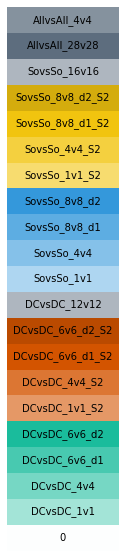

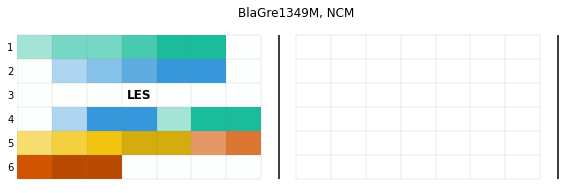

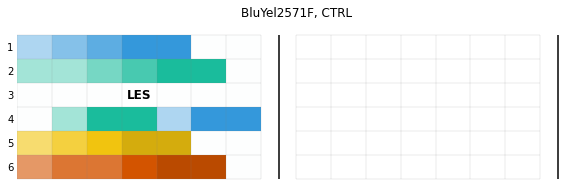

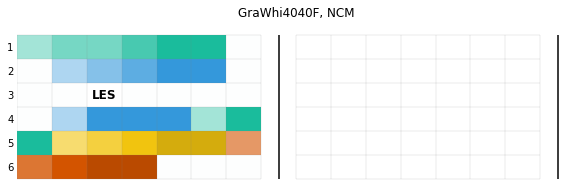

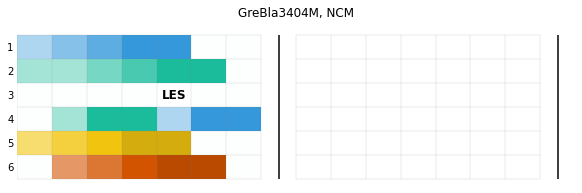

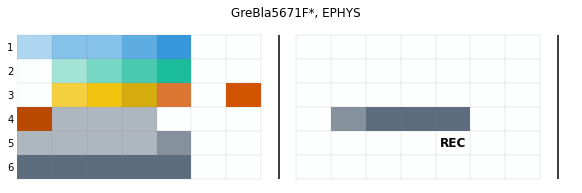

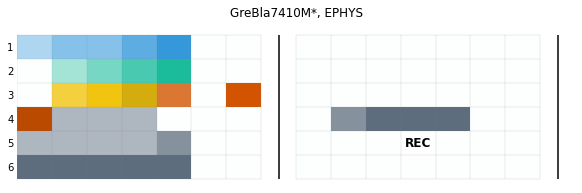

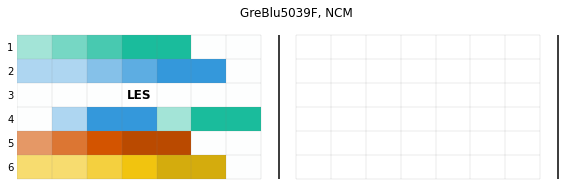

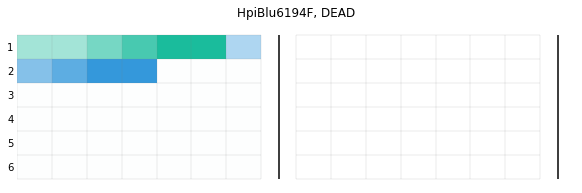

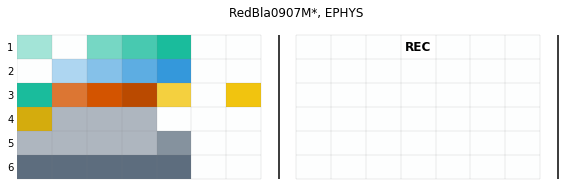

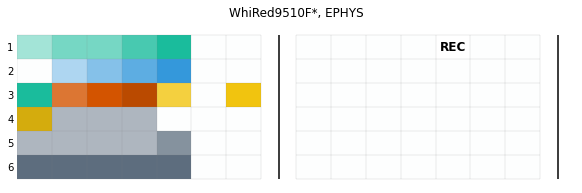

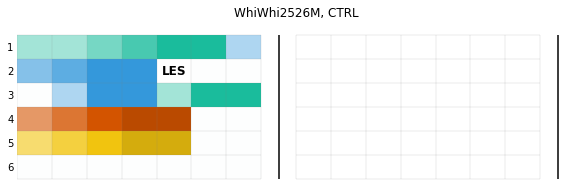

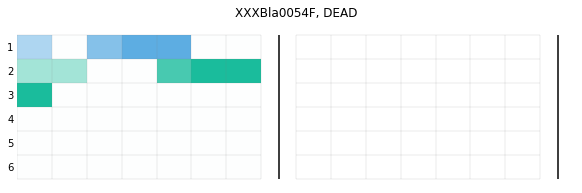

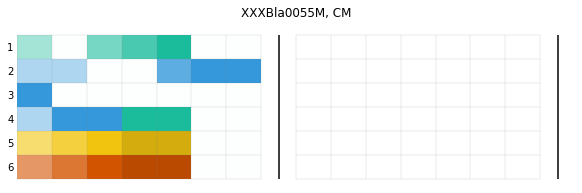

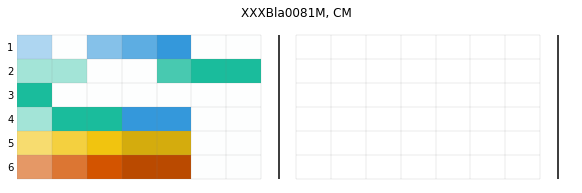

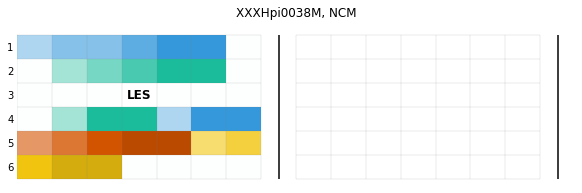

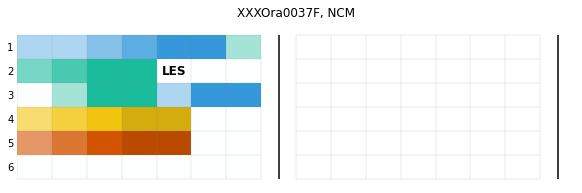

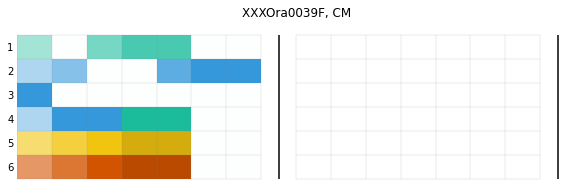

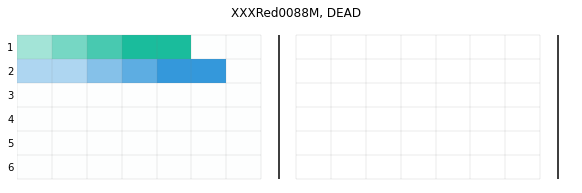

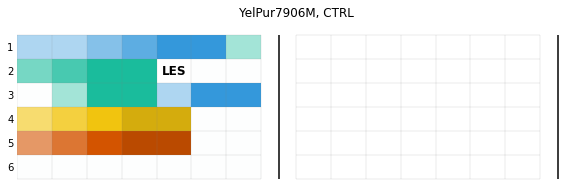

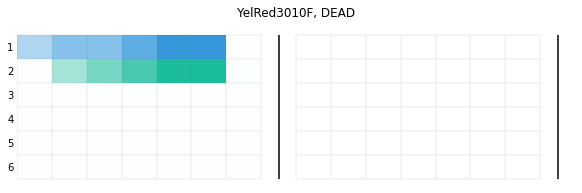

In [7]:
print("Days of behavioral tests are shown below. Subjects with associated ephys data are marked with a *")

fig = plot_legend(legend)
fig.savefig("../images/summaries/calendar_legend.svg", dpi=300, format="svg")
plt.show()
plt.close(fig)

for (subject, subject_group), subject_df in df.groupby(["Subject", "Subject Group"]):
    dates = sorted(subject_df.Date.unique())
    first = dates[0]
    last = dates[-1]
    
    if subject in lesion_df["Subject"].unique():
        lesion_date = lesion_df[lesion_df["Subject"] == subject].iloc[0]["Date_Lesioned"]
        if lesion_date > last:
            last = lesion_date
    else:
        lesion_date = None
        
    if subject in ephys_df["subject"].unique():
        ephys_date = ephys_df[ephys_df["subject"] == subject].iloc[0]["date"]
        if ephys_date > last:
            last = ephys_date
    else:
        ephys_date = None
        
    n_days = (last - first).days
    
    calendar = generate_pseudo_calendar(n_days, rows=6, dtype=object)
    
    for (date, test_context), _  in subject_df.groupby(["Date", "Test Context"]):
        calendar.set_by_idx((date - first).days, test_context)
    
    if lesion_date:
        calendar.set_by_idx((lesion_date - first).days, "Lesion")
    if ephys_date:
        calendar.set_by_idx((ephys_date - first).days, "Ephys")
    
    fig = plt.figure(figsize=(10, 3))
    ax = plt.gca()
    ax.set_title("{}{}, {}".format(subject, "*" if subject in ephys_subjects else "", subject_group))
    plot_calendar(calendar, show_months=2, ax=ax)
    fig.savefig("../images/summaries/calendar_{}.svg".format(subject), dpi=300, format="svg")
    plt.show()
    plt.close(fig)